# Forecasting electricity load using temperature and Fbprophet (Fourier and GAN model)

– Jon Tingvold, april 2019

#### Abstract
Modeling and forecasting electricity load is an important task for grid operators and electricity retailing companies when they participate in the day-ahead market. Electricity load contains large seasonal variation, and in Norway, the load depends heavily on temperature. Here we use Fbprophet to model electricity load. Fbprophet uses a generalized additive model (GAM) where seasonality is modeled with Fourier series, and temperature and holidays are modeled as linear regressors. The model performs quite well with a mean average error (MAE) of **536.56 MW** (3.9%) over a 12–36 hours ahead forecast. However, without other models to compare it to, it is hard to know how good it is.

#### Introduction
In Norway, the electricity load is heavily dependent on temperatures as electricity is used for heating (indifference to Danmark and Germany, where it is normal to use natural gas). The electricity load has also a heavily seasonal component. The load is larger during the day and evening (than nights), it is larger on weekdays and workdays (than weekends and holidays), and larger in the winter (than summer) because of heating and more use of lights.

Such time-series with complex seasonality can be timely to model from scratch.

#### The model
Fbprophet is a tool build by Facebook to do time series forecasting almost without configuration. It uses a generalized additive model (GAM) where daily, weekly and yearly seasonality is modeled as Fourier series (the Fourier series' order can be specified). Holiday's are modeled with dichotomous regression variables (Fbprophet keeps a record of each countries holiday's and their date each year if it varies like easter). Additional variables, like temperature, are modeled as linear regressors. And last, the trend is modeled as a linear growth, but with breakpoints where the growth rate is varied e.g. each other month, to pick up changing trends.

This looks like a good model for electricity load. Heating demand depends almost linearly with temperature (as long as it is under 18 degrees). Heating, daily, weekly, yearly and holiday variation as probably limited interactive effects with each other.

The only problem is that temperature shows strong daily and yearly variation. Such colinearity makes it hard to decouple and measure these the temperature and other seasonal effects independently from each other. It might also lead to unstable estimates of the regression parameters.

Although not relevant here, you can configure Fbprophet to have multiplicate seasonality, to model log-linear exponential growths, or have a saturated growth trend.

#### Dataset
The data consist of electricity load and temperature with hourly resolution in Norway between 2010–2016 (seven full years). The data of electricity load in the Norwegian grid is taken from ENTSO-E, a network of European TSO's like Statnett.

The temperature is the population-averaged temperature in Norway and is taken from the NASA MERRA-2 reanalysis weather dataset.

#### Evaluation
The model fit looks quite good. 

With an average load of **14,000 MW**, and a day-night difference of **3000 MW**, a mean average error (MAE) of **530 MW (3.9%)** in a 12–36 hours ahead forecast **1210 MW (8%)** in a 365 days ahead forecast, and is far from bad, although it could probably be better. Without changepoints the 12–36 hours ahead forcast the MAE went up to **586 MW (4.1%)**. Without temperature as a regressor, the MAE went up to **1114 MW (6.5%)**.

There are a few minor problems: The estimated load looks a bit underestimated during periods with low temperature. And while the model is good at modeling load on holidays like Christmas eve, it overestimates it between Christsmas eve and new year's eve, because it thinks it is workdays. The performance of Fbprophet is also a bit slow.

However, most of the error probably comes from factors that are not included in the model, more than the specificity or calibration of the model itself.

The colinearity between temperature and seasonal effects does not seem to be a problem.

#### Conclusion

It seems like a decent model with quite good fit. Although, without models to compare it with, it is hard to know how good it is.


# Code

##### Setup

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import fbprophet
import sklearn
import sklearn.metrics
import math

from IPython.display import display, HTML, Image, Video

# Matplotlib style sheet
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-pastel')
plt.style.use('jont')

## Dataset

,load_mw,temp_c
datetime,,
2010-01-01 00:00:00,17898.0,-9.958
2010-01-01 01:00:00,17671.0,-9.953
2010-01-01 02:00:00,17500.0,-10.098
2010-01-01 03:00:00,17362.0,-10.344
2010-01-01 04:00:00,17470.0,-10.586


,load_mw,temp_c
datetime,,
2016-12-31 19:00:00,15771.47,1.720
2016-12-31 20:00:00,15483.59,1.540
2016-12-31 21:00:00,15237.38,1.343
2016-12-31 22:00:00,15018.43,1.061
2016-12-31 23:00:00,14911.72,0.905


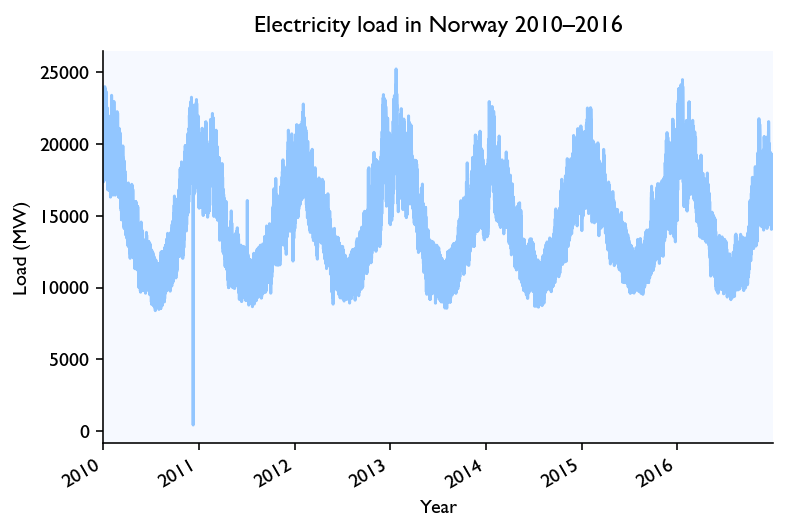

In [21]:
# Load dataset
filename = "NO_load_actual_entsoe_power_statistics.csv"
dataset = pd.read_csv(filename)
dataset.index = pd.to_datetime(dataset.datetime)
dataset = dataset.drop(columns=["datetime"])

display(dataset.head())
display(dataset.tail())

# Plot df
figure = dataset.load_mw.plot(legend=False)
figure.set(xlabel="Year", ylabel="Load (MW)")
figure.set_title(label="Electricity load in Norway 2010–2016")
figure;

### Correlation between load and temperature
Fairly strong correlation between temperature and load in Norway, as we use electricity for heating.

The relationship seems quite linear.

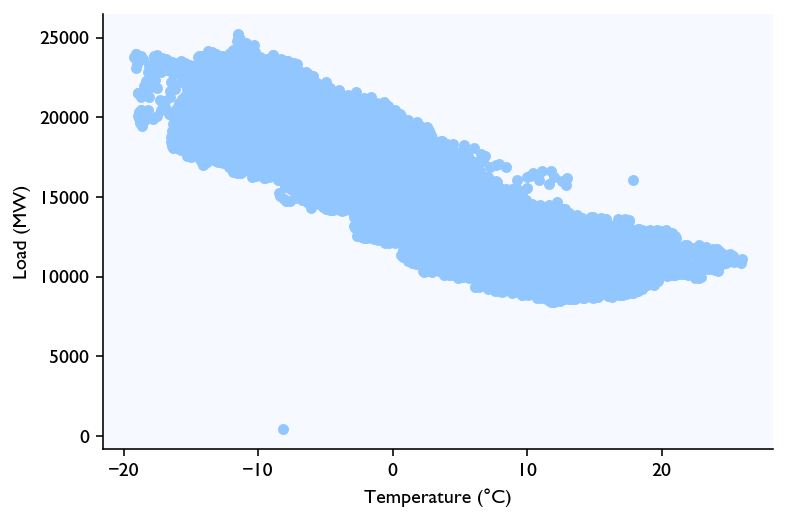

In [3]:
figure = dataset.plot.scatter(x="temp_c", y="load_mw")
figure.set(xlabel="Temperature (°C)", ylabel="Load (MW)")
figure;

## Model

#### Model setup

In [4]:
# Configure data frame so it is compatable with Fbprophet
# Dataset, except forecasting period

dataset_for_model = pd.DataFrame({
    "ds": dataset.index, 
    "y": dataset.load_mw,
    "temp": dataset.temp_c
})

# Set up model
model = fbprophet.Prophet(
    daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=False,
    #changepoint_prior_scale=0.001
)
model.add_seasonality(name='yearly', period=365.25, fourier_order=4)
model.add_country_holidays(country_name='NO')
model.add_regressor("temp")

# Fit model to data
model.fit(dataset_for_model)

# Predict
prediction_data = model.predict(dataset_for_model)

In [5]:
# Add actual load y
prediction_data["y"] = list(dataset.load_mw)

### Model components

#### Plot of model components
Extra regressors additive == temperature

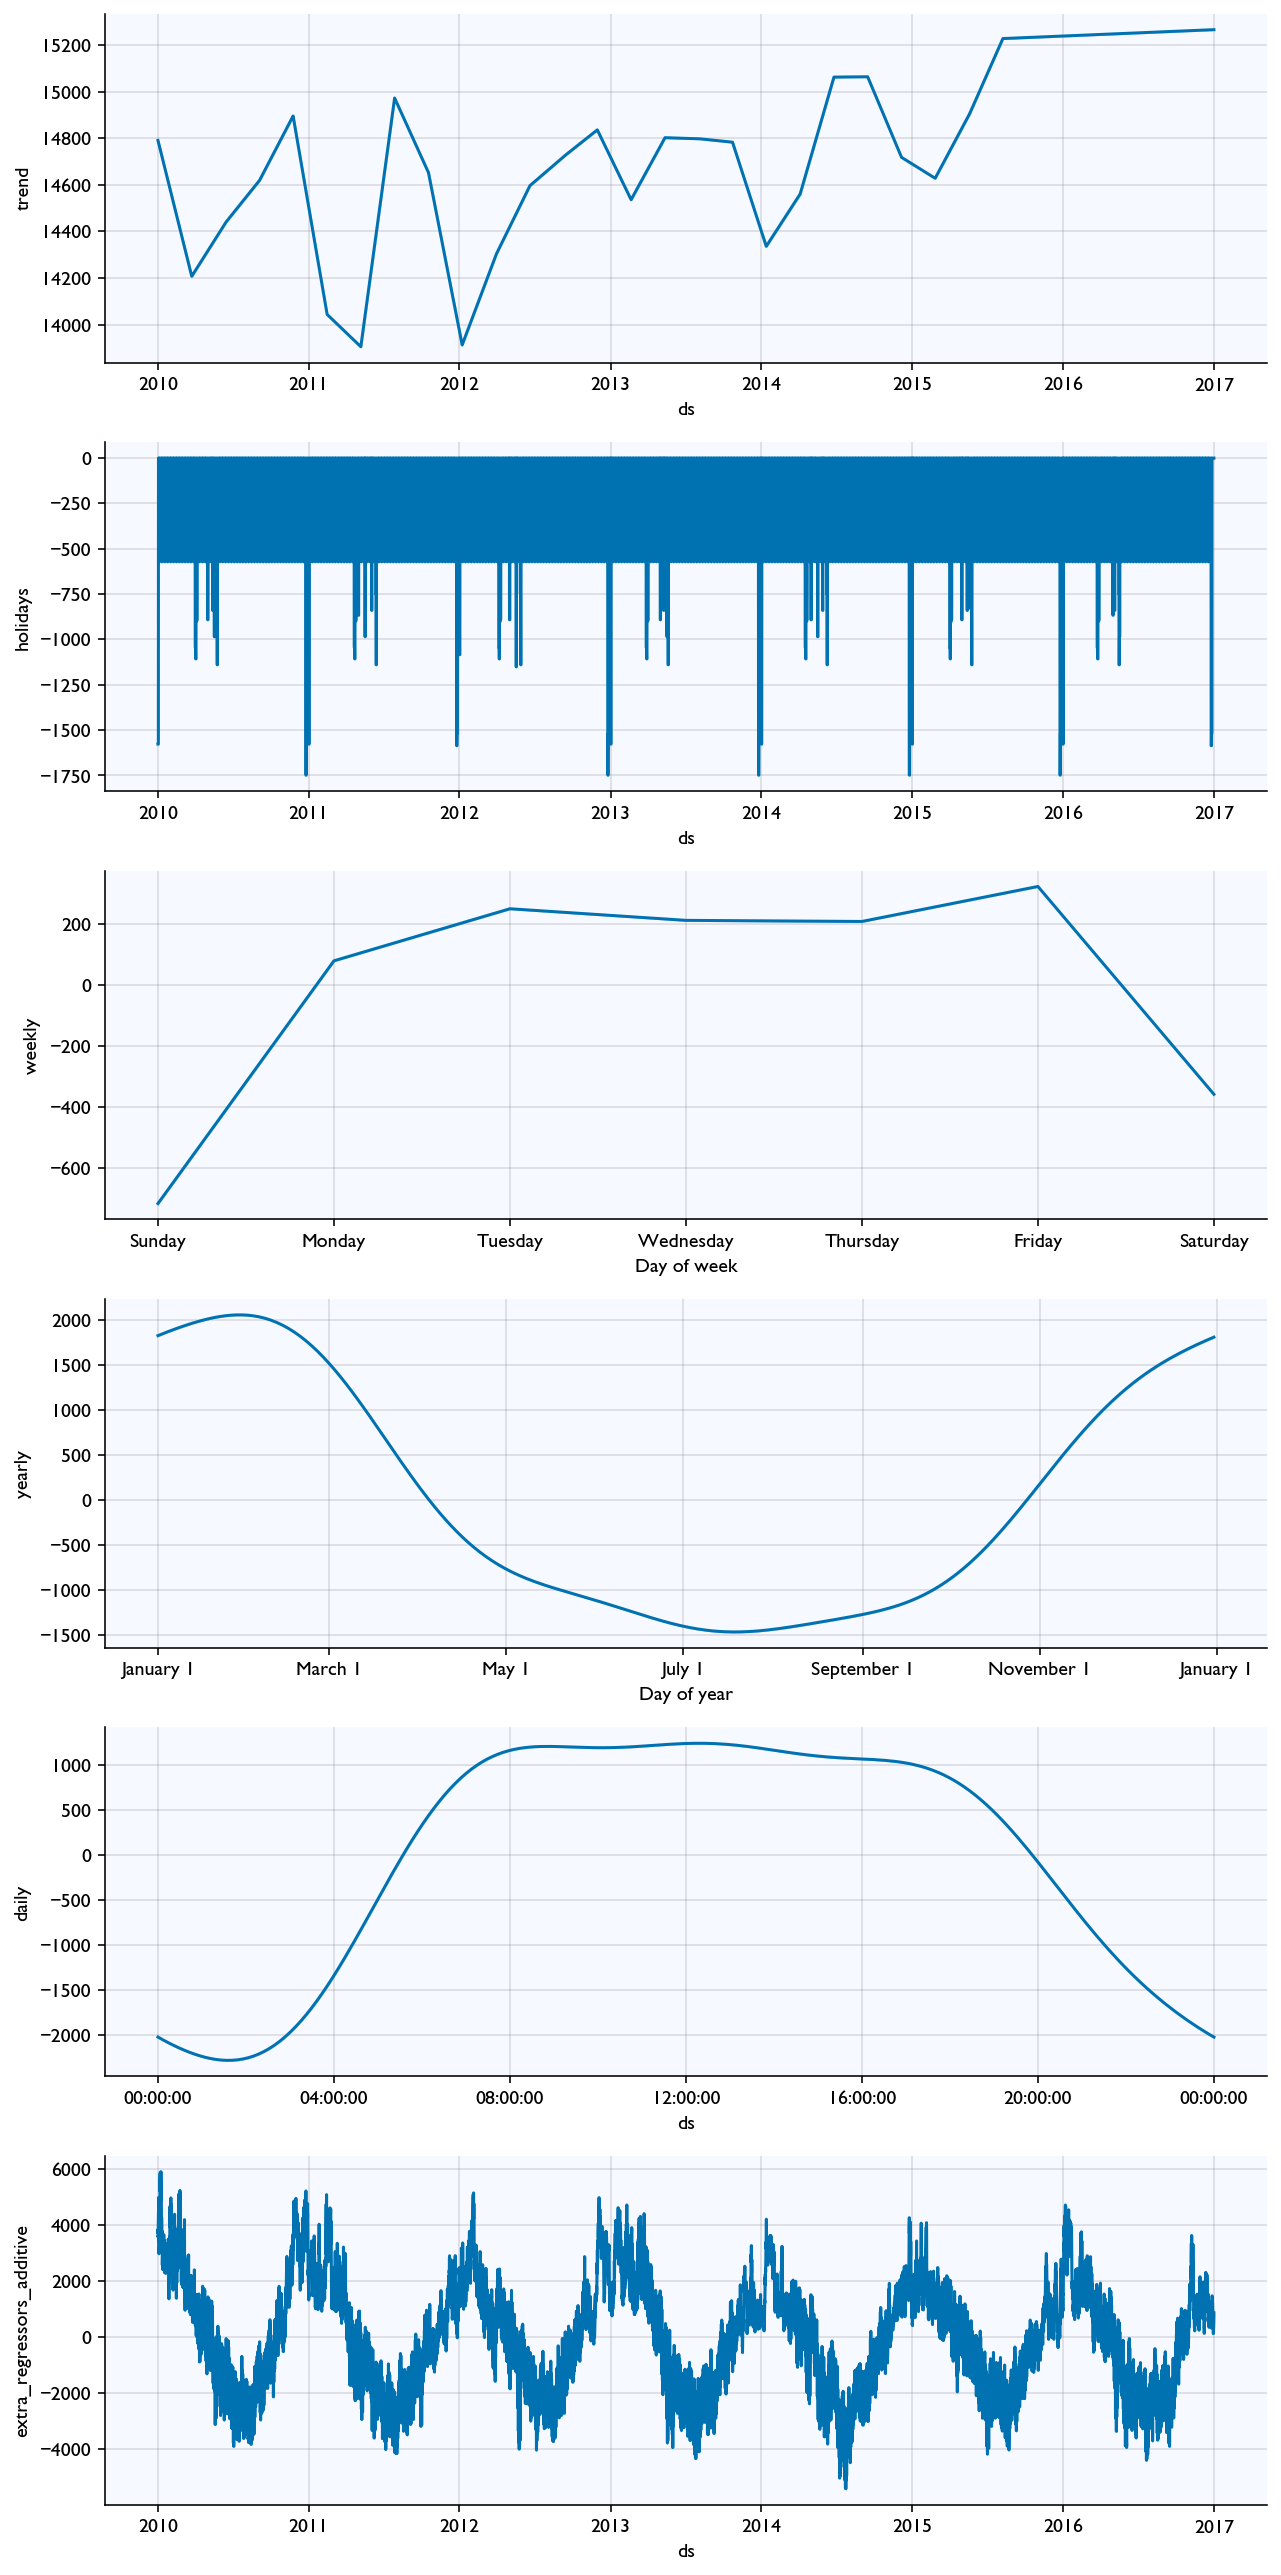

In [6]:
fig = model.plot_components(prediction_data)

## Model fit

In [7]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-01-22 23:00:00 and 2016-01-01 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-01-23 00:00:00,17226.052040,16518.970877,17981.639060,16070.0,2012-01-22 23:00:00
1,2012-01-23 01:00:00,17082.870492,16323.037936,17839.674115,16046.0,2012-01-22 23:00:00
2,2012-01-23 02:00:00,17123.135667,16384.697631,17820.248577,16079.0,2012-01-22 23:00:00
3,2012-01-23 03:00:00,17450.537308,16757.597606,18175.095212,16362.0,2012-01-22 23:00:00
4,2012-01-23 04:00:00,18126.203161,17389.311336,18889.962428,17078.0,2012-01-22 23:00:00



#### Plot dataset with estimated load (yhat)

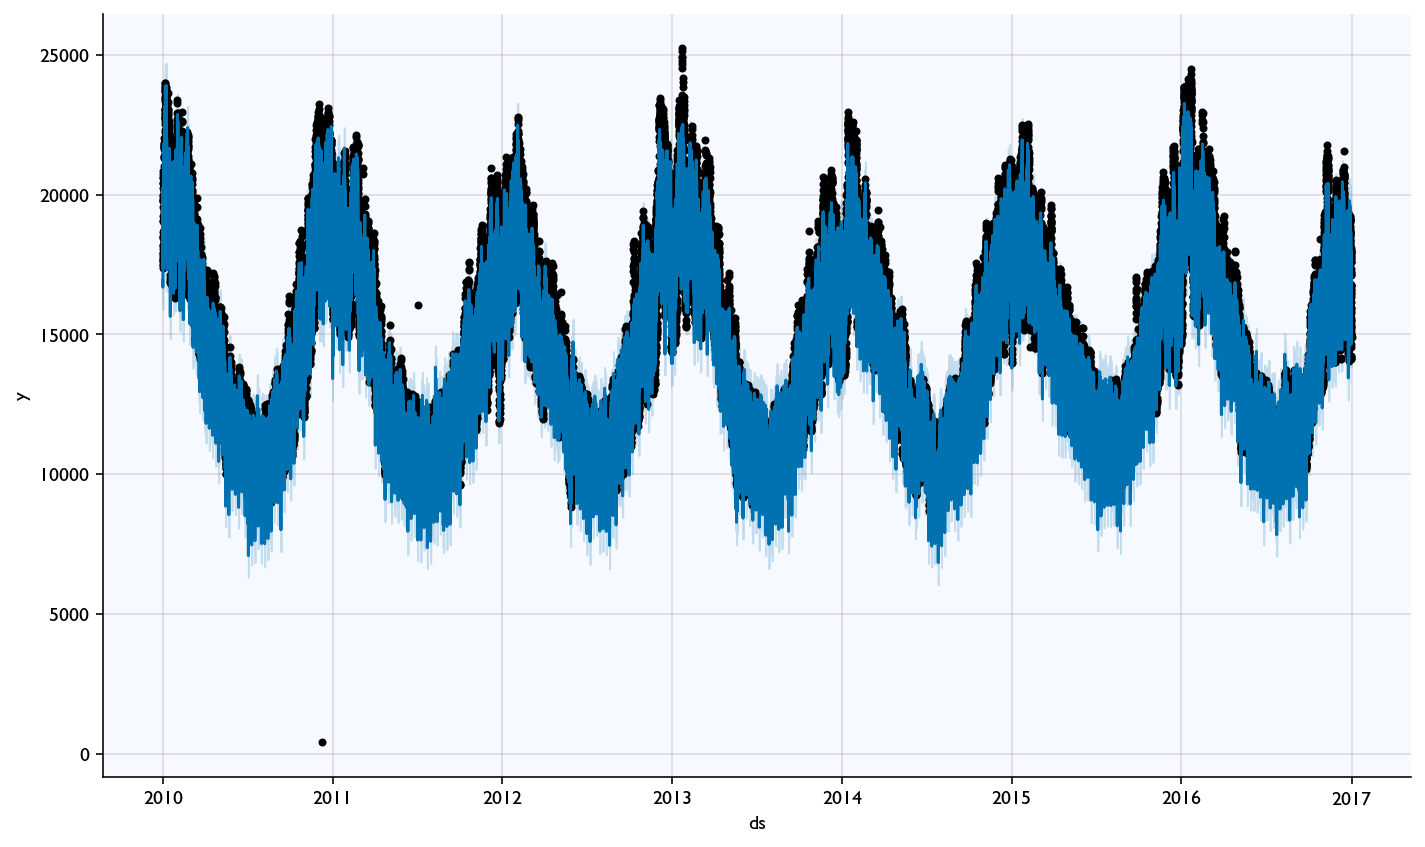

In [8]:
fig = model.plot(prediction_data)

#### One year

In [9]:
ds = pd.DataFrame({"y":df_cv.y, "yhat":df_cv.yhat})
ds.index = pd.to_datetime(df_cv.ds)

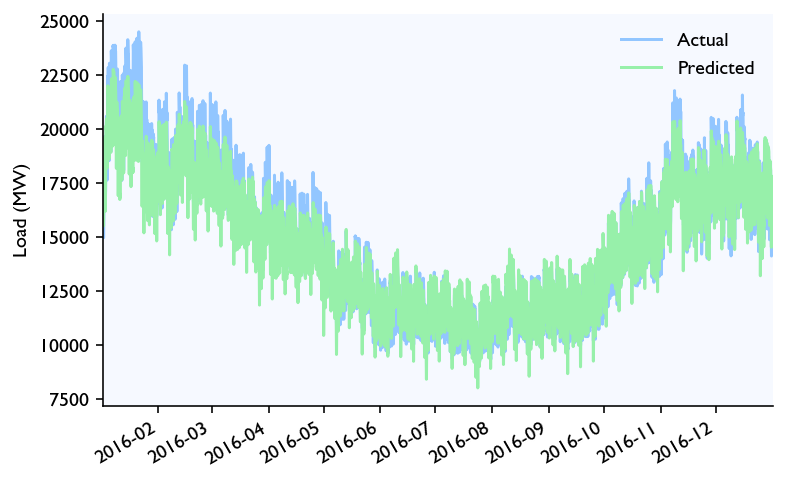

In [10]:
days = 365

# Bugfix: fbprophet deregisters some pandas plot stuff
pd.plotting.register_matplotlib_converters()

figure = ds[-days*24:].plot()
figure.set(xlabel="", ylabel="Load (MW)")
figure.legend(["Actual", "Predicted"]);
figure;

#### 14 day cold days in november

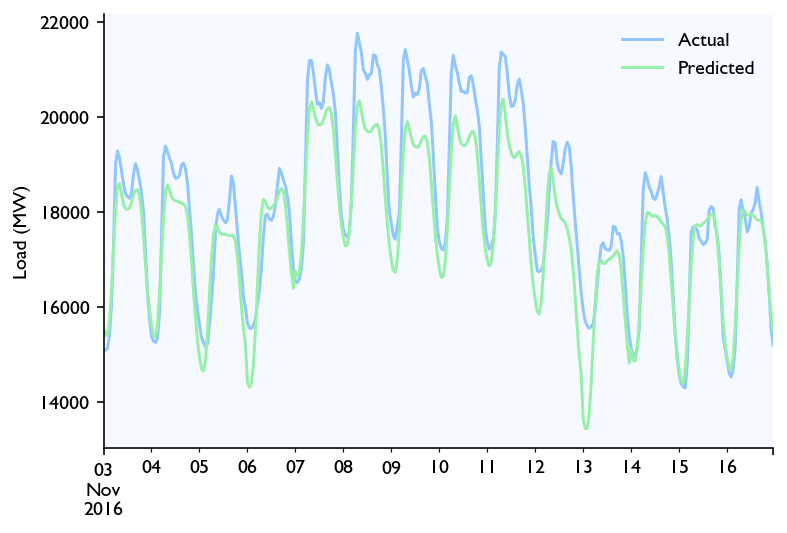

In [11]:
days_before_2016_12_31 = 45

df = df_cv
slice_of_last_14days = slice(-(days_before_2016_12_31+14)*24, -days_before_2016_12_31*24)

last_14d = pd.DataFrame({"y":df.y[slice_of_last_14days], "yhat":df.yhat[slice_of_last_14days]})
last_14d.index = pd.to_datetime(df.ds[slice_of_last_14days], utc=True)

 # Bugfix: fbprophet deregisters some pandas plot stuff
pd.plotting.register_matplotlib_converters()

figure = last_14d.plot()
figure.set(xlabel="", ylabel="Load (MW)")
figure.legend(["Actual", "Predicted"]);
figure;

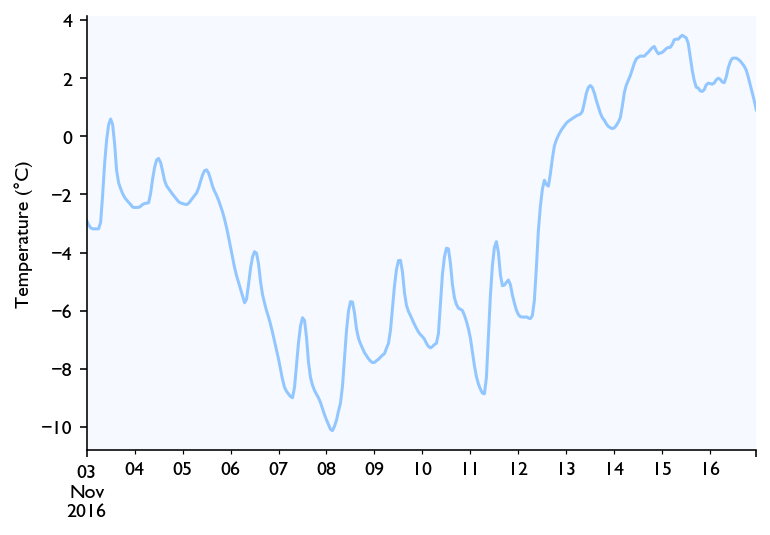

In [12]:
figure = dataset.temp_c[slice_of_last_14days].plot()
figure.set(xlabel="", ylabel="Temperature (°C)")
figure;

When the temperature fall and load rises, it looks like the model underestimates the load slightly.

#### During christmas eve

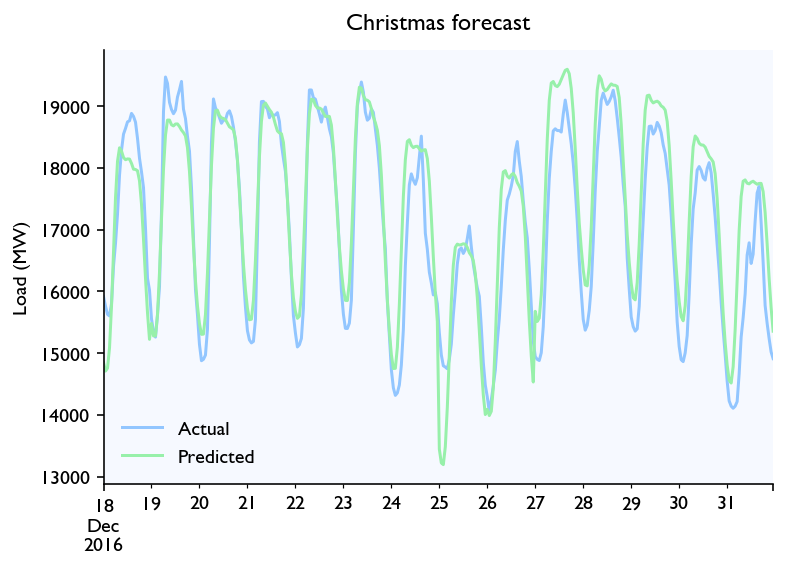

In [13]:
figure = ds[-14*24:].plot()
figure.set(xlabel="", ylabel="Load (MW)", title="Christmas forecast")
figure.legend(["Actual", "Predicted"]);
figure;

The model is quite good at estimating the decreased load around Christmas eve. However, during the non-official Christmas holiday between Dec 26–30th, the estimate is a bit too high.

#### Create scatter plot of actual and estimated load (y and yhat)

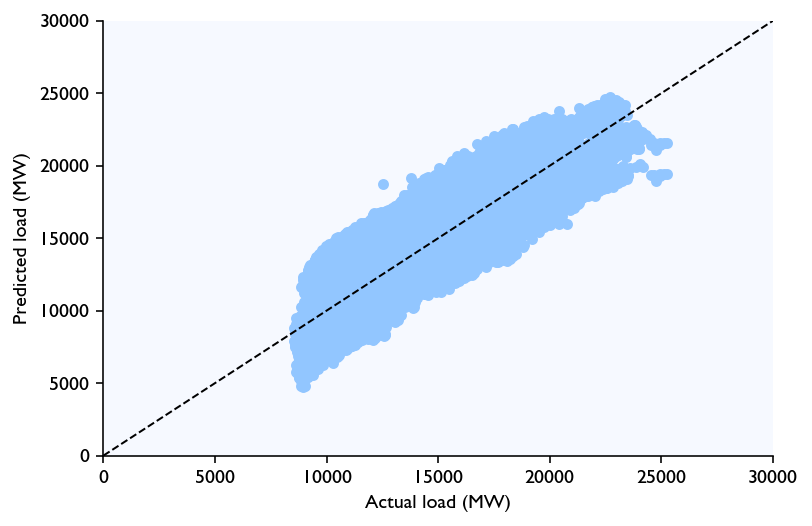

In [14]:
df = df_cv[["ds", "y", "yhat"]]

fig = df.plot.scatter(x="y", y="yhat")
fig.set(xlabel="Actual load (MW)", ylabel="Predicted load (MW)")
fig.axes.set_xlim(0, 30000)
fig.axes.set_ylim(0, 30000)
fig.plot(fig.get_xlim(), fig.get_ylim(), color='black', linestyle='--', lw=1)
fig;

# Evaluation metrics
The model fit looks quite good. 

With an average load of **14,000 MW**, and a day-night difference of **3000 MW**, a mean average error (MAE) of **530 MW (3.9%)** in a 12–36 hours ahead forecast **1210 MW (8%)** in a 365 days ahead forecast, and is far from bad, although it could probably be better. Without changepoints the 12–36 hours ahead forcast the MAE went up to **586 MW**. Without temperature as a regressor, the MAE went up to **1114 MW**.

In [15]:
print("R2 without cross validation: %.2f" % sklearn.metrics.r2_score(prediction_data.y, prediction_data.yhat))
print("R2 cross-validation 0–365 day forecasts: %.2f" % sklearn.metrics.r2_score(df_cv.y, df_cv.yhat))

R2 without cross validation: 0.97
R2 cross-validation 0–365 day forecasts: 0.80


In [16]:
from fbprophet.diagnostics import performance_metrics
df_pp = performance_metrics(df_cv, rolling_window=0.0)

In [17]:
df_pp.head(5)

,horizon,mse,rmse,mae,mape,coverage
0,01:00:00,486568.064392,697.544310,529.189117,0.038943,0.777778
1,02:00:00,444129.054466,666.430082,529.893140,0.039676,0.777778
2,03:00:00,399371.258331,631.958273,488.042189,0.035589,0.777778
3,04:00:00,374866.040005,612.263048,507.480747,0.038070,0.777778
4,05:00:00,403089.009258,634.892912,544.771346,0.041494,0.777778


In [18]:
df_p = performance_metrics(df_cv, rolling_window=0.1)

In [19]:
print("MAE, 12–36 hours ahead: %.2f MW" % df_pp.mae[12:36].mean())
print("MAE, 0–36 hours ahead: %.2f MW" % df_pp.mae[:36].mean())
days=36;print("MAE, %i days ahead: %.2f MW" % (days, df_p.mae[(days-36)*24]))
days=60;print("MAE, %i days ahead: %.2f MW" % (days, df_p.mae[(days-36)*24]))
days=90;print("MAE, %i days ahead: %.2f MW" % (days, df_p.mae[(days-36)*24]))
days=120;print("MAE, %i days ahead: %.2f MW" % (days, df_p.mae[(days-36)*24]))
days=180;print("MAE, %i days ahead: %.2f MW" % (days, df_p.mae[(days-36)*24]))
days=365;print("MAE, %i days ahead: %.2f MW" % (days, df_p.tail(1).mae.values[0]))

MAE, 12–36 hours ahead: 536.56 MW
MAE, 0–36 hours ahead: 551.45 MW
MAE, 36 days ahead: 706.89 MW
MAE, 60 days ahead: 735.92 MW
MAE, 90 days ahead: 888.41 MW
MAE, 120 days ahead: 965.55 MW
MAE, 180 days ahead: 1206.37 MW
MAE, 365 days ahead: 1210.75 MW


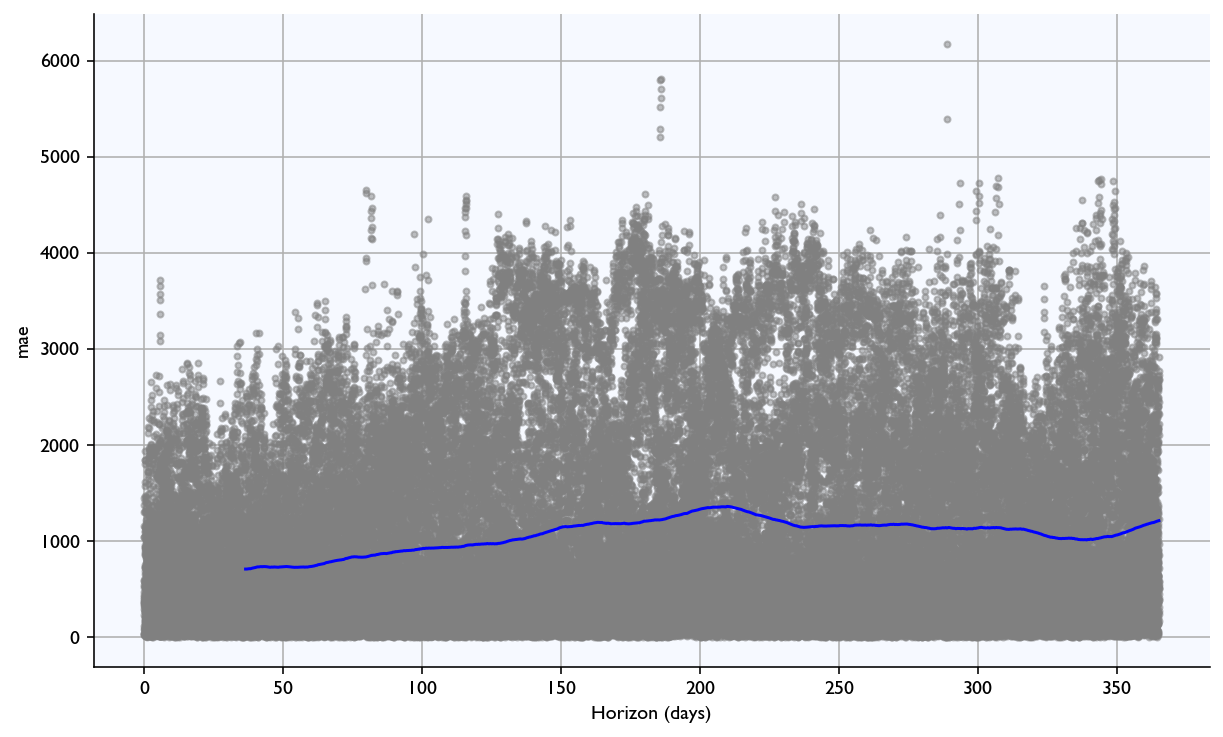

In [20]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')